In [1]:
library(Seurat)
library(tidyverse)
library(foreach)
library(doParallel)
library(ggpubr)
source("/shareb//zliu//analysis/hires_gastrulation/CHARMtools/Rlibs/plotFun.R")
library(ComplexHeatmap)
options(bedtools.path = "~/miniconda3/envs/py3/bin")
library(bedtoolsr)
options(scipen=999)

Registered S3 method overwritten by 'spatstat.geom':
  method     from
  print.boxx cli 

Attaching SeuratObject

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘foreach’


The followin

In [12]:
allgadi_bedpe <- read_tsv("/shareb/zliu/analysis/hires_mouse_dev/figure3_related_new/di_emb_nonp/hires_emb_gadi.tsv.gz")

Rows: 390252 Columns: 12
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): chrom1, chrom2, name, pos, GADI_id
dbl (7): start1, end1, start2, end2, cor, pv, fdr_cor

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [2]:
celltypeColors = c(
"mitosis"="#bebebe","blood"="#ff9400",
"ExE endoderm"="#fec44f", "ExE ectoderm"="#cab2d6", 
"epiblast and PS"="#addd8e",
#neural
"neural ectoderm"="#AECBE6","NMP"="#96B9DB","neural tube"="#7EA8D0","notochord"="#6696C6","radial glias"="#4F85BB","oligodendrocytes and progenitors"="#3773B1","early neurons"="#1F62A6","schwann cell precursors"="#08519C",
#mesodermal
"early mesoderm"="#FC9272","ExE mesoderm"="#EF7F64","early mesenchyme"="#E36C57","intermediate mesoderm"="#D6594A", "myocytes"="#CA473C","mix late mesenchyme"="#BD342F",
"endoderm"="#fe9929","epithelial cells"="#fa9fb5"
)
cellcyclecolors = c("G0"="#762a83","G1"="#c2a5cf","Early-S"="#99d8c9","Mid-S"="#66c2a4","Late-S"="#41ae76","G2"="#238b45","M"="#ea6e34")
hires <- readRDS("/shareb/zliu/analysis/hires_mouse_dev/hires_mouse_emb_dev.new.rds")

In [135]:
hires <- readRDS("/shareb/zliu/analysis/hires_mouse_dev/hires_mouse_emb_dev.new.rds")

In [137]:
hires[[]] %>% names()

[1] "cellname"            "maxbinorder"         "UMAP_1"             
 [4] "UMAP_2"              "orig.ident"          "nCount_RNA"         
 [7] "nFeature_RNA"        "Rawreads"            "DNAreads"           
[10] "RNAreads"            "yperx"               "raw_pairs"          
[13] "pairs_dedup"         "pairs_clean1"        "pairs_clean2"       
[16] "inter_pairs_clean2"  "UMIs_gene"           "genes_gene"         
[19] "UMIs_exon"           "genes_exon"          "UMIs_gene_genome1"  
[22] "genes_gene_genome1"  "UMIs_gene_genome2"   "genes_gene_genome2" 
[25] "RNAreadsRatio"       "pairsPerRead"        "pairsValidRatio"    
[28] "interPairsRatio"     "pairs"               "pre_meta_score"     
[31] "order_index"         "near_p"              "mitotic_p"          
[34] "farAvg"              "NaganoCellcycle"     "repli_score"        
[37] "annote_ratio"        "stage"               "percent.mt"         
[40] "nCount_SCT"          "nFeature_SCT"        "SCT_snn_res.1.5"    
[43] "celltype"            "nCount_cpg"          "nFeature_cpg"       
[46] "nCount_cpggene"      "nFeature_cpggene"    "sch.nn_res.0.8"     
[49] "G1S.Score"           "G2M.Score"           "Phase"              
[52] "CC.Score"            "nCount_cdps"         "nFeature_cdps"      
[55] "cdps_nn_res.1"       "seurat_clusters"     "cellcycle"          
[58] "count"               "mean_G1S"            "mean_G2M"           
[61] "mean_repli"          "color"               "celltype_id"        
[64] "rmsd_20k"            "lineage"             "inter_pairs_clean3" 
[67] "cluster"             "sub_k_cluster"       "raw_repli_score"    
[70] "clusterOrder"        "varrepli"            "varnearp"           
[73] "snearp"              "sfar"                "order"              
[76] "cellcycle_threshold" "nCount_scab"         "nFeature_scab"      
[79] "pairs_clean3"

In [142]:
hires[[]] %>% select(celltype,cluster,sub_k_cluster) %>% unique() #%>% filter(celltype == "NMP")#%>% group_by(celltype) %>% summarise(count = n())

,celltype,cluster,sub_k_cluster
,<chr>,<dbl>,<dbl>
GasaE751001,ExE ectoderm,9,2
GasaE751002,neural ectoderm,11,3
GasaE751003,ExE mesoderm,7,1
GasaE751004,early mesenchyme,4,3
GasaE751005,ExE endoderm,4,1
GasaE751006,ExE endoderm,7,3
GasaE751007,mitosis,6,3
GasaE751008,blood,6,2
GasaE751009,early mesoderm,3,2


In [3]:
hires <- subset(hires,subset = celltype != "mitosis" & celltype != "ExE ectoderm" & celltype != "ExE endoderm" & cellcycle_threshold != "M" & celltype != "blood")
DefaultAssay(hires) <- "SCT"
Idents(hires)<- hires$celltype
neuron_markers <- FindMarkers(hires,`ident.1` = "early neurons",only.pos = T) %>% filter(p_val_adj < 0.01)
mesenchyme_markers <- FindMarkers(hires,`ident.1` = "mix late mesenchyme",only.pos = T) %>% filter(p_val_adj < 0.01)

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from cpg_umap_ to cpgumap_”
Warning message:
“Cannot add objects with duplicate keys (offending key: cpgumap_) setting key to original value 'cpg_umap_'”


In [4]:
mc_hires <- readRDS("/shareb/zliu/analysis/hires_mouse_dev/figure3_related_new/di_emb_nonp/hires_emb_metacell.rds")

In [5]:
a <- FeaturePlot(mc_hires,"di_pseudotime",reduction = "mcdi_umap",pt.size = 0.1) + theme_Publication() + NoLegend()  + theme(axis.ticks.x = element_blank(),
        axis.text.x = element_blank(),
         axis.ticks.y = element_blank(),
               axis.text.y = element_blank())  + ggtitle("")
b <- FeaturePlot(mc_hires,"sct_pseudotime",reduction = "mcsct_umap",pt.size = 0.1) + theme_Publication() + NoLegend() + theme(axis.ticks.x = element_blank(),
        axis.text.x = element_blank(),
         axis.ticks.y = element_blank(),
               axis.text.y = element_blank()) + ggtitle("")
(a|b) %>% ggsave(filename = "pseudotime_mc.pdf",height = 1.5,width = 3,dpi = 300)

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


In [5]:
# functions
overlap_ratio <- function(bedpe,bed){
    bed <- bed %>% select(1:3)
    names(bed) <- c("chrom","start","end")
    
    bed1_l <- bedpe %>% select(1:3)
    bed1_r <- bedpe %>% select(4:6)

    names(bed1_l) <- c("chrom","start","end")
    names(bed1_r) <- c("chrom","start","end")
    names(bed) <- c("chrom","start","end")
    
    bed1_l_intersect <- valr::bed_intersect(bed1_l%>% mutate(id = row_number()),bed)  %>% select(1:4) %>% unique()
    bed1_r_intersect <- valr::bed_intersect(bed1_r%>% mutate(id = row_number()),bed)  %>% select(1:4) %>% unique()
    
    intersected <- full_join(bed1_l_intersect,bed1_r_intersect,by="id.x")
    a=dim(intersected %>% filter(chrom.x == chrom.y))[1]
    b=dim(intersected)[1]
    c=dim(bedpe)[1]
    return(c(a/c,b/c))
}

dynamic_postprocess <- function(dynamics){
    temp <- dynamics %>%  group_by(gene,gadi,type) %>% mutate(norm_value = (value - min(fitted_raw))/(max(fitted_raw) - min(fitted_raw))) %>% 
     select(-c(value,fitted_raw,fitted,high,low)) %>% group_by(type) %>% mutate(id = row_number()) %>% spread(type,norm_value)  %>% mutate(residue = GADI - RNA) %>% na.omit()  %>%
      group_by(gene,gadi) 
    testres = temp %>% group_by(gene,gadi) %>% summarise(residual = mean(GADI-RNA),pv = t.test(GADI-RNA,mu=0)$p.value,t=t.test(GADI-RNA,mu=0)$statistic) %>% ungroup()
    testres <- testres %>% group_by(gene)  %>% mutate(fdr = p.adjust(pv,method="BH")) %>% 
        mutate(type = ifelse(sign(t)==1,"early","lag"),sigtype = ifelse(fdr < 0.05,"sig","not")) 
    testres %>% mutate(test_type = ifelse(sigtype == "sig",type,"notSig"))%>% mutate(gaditype = str_extract(gadi,"neg|pos"),gadi=str_remove_all(gadi,"pos|neg")) %>% 
        separate(gadi,into = c("chrom","bin1","bin2")) %>% mutate(bin1 = as.numeric(bin1),bin2 = as.numeric(bin2)) %>% 
        mutate(start1=bin1 - 10000,start2=bin2-10000,end1 = bin1 + 10000,end2 = bin2+ 10000,chrom1 = chrom,chrom2 = chrom) %>% 
        select(chrom1,start1,end1,chrom2,start2,end2,gaditype,test_type,residual,pv,fdr,t,gene) %>% ungroup() -> testres
    return(testres)
}

plot_dynamic_enrichment <- function (testRes, gadi_type, feature_bed, title, numbin = 100, 
    outdir = "residual_enrichment", save = FALSE,type ="one") 
{
    feature = deparse(substitute(feature_bed))
    neural_testRes_rank <- testRes %>% filter(gaditype == gadi_type) %>% 
        arrange(desc(residual)) %>% mutate(rankgroup = ntile(seq(n()), 
        numbin)) %>% ungroup()
    types <- neural_testRes_rank %>% group_by(rankgroup, test_type) %>% 
        mutate(votes = n()) %>% group_by(rankgroup) %>% summarise(majority_vote = test_type[votes > 
        n()/2][1]) %>% pull(majority_vote)
    if(type == "one"){
        residual_enrich <- map(seq(numbin), function(x) {
            overlap_ratio(neural_testRes_rank %>% filter(rankgroup == 
                x), feature_bed)[2]
        }) %>% unlist()
        print("one")
    }else{
         print("both")
        residual_enrich <- map(seq(numbin), function(x) {
                overlap_ratio(neural_testRes_rank %>% filter(rankgroup == 
                    x), feature_bed)[1]
            }) %>% unlist()
    }
    options(repr.plot.width = 4.5, repr.plot.height = 5, repr.plot.res = 200)
    p <- cbind(seq(numbin), types, residual_enrich) %>% as.data.frame() %>% 
        mutate(V1 = as.numeric(V1), residual_enrich = as.numeric(residual_enrich)) %>% 
        mutate(types = ifelse(types == "early", "Proceeding", 
            ifelse(types == "lag", "Succeeding", "Not Sig"))) %>% 
        ggscatter(x = "V1", y = "residual_enrich", color = "types", size = 0.1,
            palette = c(Proceeding = "#b2182b", `Not Sig` = "#969696", 
                Succeeding = "#2166ac")) + ylab(paste0("percent of ", 
        feature)) + xlab("residual group rank") + theme_Publication() + 
        ggtitle(title)
    if (save == FALSE) {
        p %>% ggsave(filename = paste0(outdir, "/", title, "_", 
            feature, ".svg"), width = 4.5, height = 5)
    }
    return(p)
}

In [6]:
mesen_dynamics <- readRDS("/shareb/zliu/analysis/hires_mouse_dev/figure3_related_new/di_emb_nonp/residuals_dynamic.mesen.rds.gz")
neural_dynamics <- readRDS("/shareb/zliu/analysis/hires_mouse_dev/figure3_related_new/di_emb_nonp/residuals_dynamic.neu.rds.gz")
neural_testRes <- dynamic_postprocess(neural_dynamics)
mesen_testRes <- dynamic_postprocess(mesen_dynamics)

`summarise()` has grouped output by 'gene'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'gene'. You can override using the `.groups` argument.


In [7]:
mesen_testRes %>% filter(!gene %in% rownames(neuron_markers),gaditype == "neg")  %>% filter(test_type == "lag",t < -3) %>% arrange(fdr) %>% mutate(pos = paste0(chrom1,"-",start1+10000,"-",start2+10000)) %>% 
    group_by(gene) %>% slice(1)  %>% arrange(fdr) %>% filter(residual<(-0.3) )

chrom1,start1,end1,chrom2,start2,end2,gaditype,test_type,residual,pv,fdr,t,gene,pos
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
chr9,118350000,118370000,chr9,119070000,119090000,neg,lag,-0.5439007,0.0000004420524,0.00001879344,-5.493924,Itga9,chr9-118360000-119080000
chr17,67650000,67670000,chr17,68070000,68090000,neg,lag,-0.4717546,0.0000012476871,0.00003761551,-5.239932,Arhgap28,chr17-67660000-68080000
chr3,141710000,141730000,chr3,142090000,142110000,neg,lag,-0.4772670,0.0000471820559,0.00046068135,-4.300657,Unc5c,chr3-141720000-142100000
chr4,83070000,83090000,chr4,83250000,83270000,neg,lag,-0.4048904,0.0001396497747,0.00067676429,-3.999120,Frem1,chr4-83080000-83260000
chr19,53050000,53070000,chr19,53650000,53670000,neg,lag,-0.4596423,0.0000148366392,0.00176556006,-4.609991,Add3,chr19-53060000-53660000
chr6,101070000,101090000,chr6,101410000,101430000,neg,lag,-0.4515654,0.0007856636249,0.00268779661,-3.489489,Pdzrn3,chr6-101080000-101420000
chr1,178970000,178990000,chr1,179530000,179550000,neg,lag,-0.3424504,0.0000445910136,0.00468205643,-4.316030,Kif26b,chr1-178980000-179540000
chr10,38870000,38890000,chr10,39470000,39490000,neg,lag,-0.3630322,0.0000206381518,0.00590251142,-4.522879,Lama4,chr10-38880000-39480000
chr1,11230000,11250000,chr1,11570000,11590000,neg,lag,-0.3829692,0.0005924504121,0.00947920659,-3.575724,Prex2,chr1-11240000-11580000


In [29]:
mesen_testRes %>% filter(gene == "Prkg1") %>% arrange(fdr)

chrom1,start1,end1,chrom2,start2,end2,gaditype,test_type,residual,pv,fdr,t,gene
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
chr19,30230000,30250000,chr19,31690000,31710000,neg,lag,-0.2863080,0.00000005735736,0.000007578946,-5.980939,Prkg1
chr19,30370000,30390000,chr19,30890000,30910000,neg,lag,-0.6040267,0.00000007358200,0.000007578946,-5.922320,Prkg1
chr19,30190000,30210000,chr19,31730000,31750000,neg,lag,-0.2814399,0.00000043189195,0.000013425048,-5.499560,Prkg1
chr19,30390000,30410000,chr19,30930000,30950000,neg,lag,-0.6401157,0.00000036093481,0.000013425048,-5.542986,Prkg1
chr19,31890000,31910000,chr19,32630000,32650000,neg,lag,-0.2732081,0.00000044228491,0.000013425048,-5.493796,Prkg1
chr19,31910000,31930000,chr19,32650000,32670000,neg,lag,-0.2764663,0.00000045619095,0.000013425048,-5.486289,Prkg1
chr19,31910000,31930000,chr19,32670000,32690000,neg,lag,-0.2724248,0.00000044021576,0.000013425048,-5.494933,Prkg1
chr19,31910000,31930000,chr19,32630000,32650000,neg,lag,-0.2862676,0.00000053067432,0.000013664864,-5.449554,Prkg1
chr19,30210000,30230000,chr19,31690000,31710000,neg,lag,-0.2294777,0.00000070940015,0.000016237381,-5.378763,Prkg1


Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'



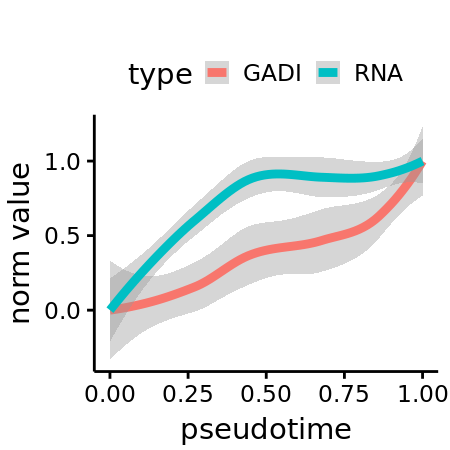

In [30]:
options(repr.plot.width = 1.5,repr.plot.height=1.5,repr.plot.res= 300)
lag <- mesen_dynamics %>% filter(gene == "Prkg1",gadi == "chr19-30240000-31700000neg") %>% 
    group_by(gene,gadi,type) %>% mutate(norm_value = (value - min(fitted_raw))/(max(fitted_raw) - min(fitted_raw))) %>% 
     select(-c(value,fitted_raw,fitted,high,low)) %>% 
    group_by(type)  %>% ggplot(aes(x=pseudotime,y=norm_value,color=type))+ geom_smooth(aes(group=type),level = 0.95) + theme_Publication() + ggtitle("") + ylab("norm value")# + NoLegend()
lag

In [10]:
mc_hires

An object of class Seurat 
571318 features across 158 samples within 2 assays 
Active assay: mc_di (535780 features, 0 variable features)
 1 other assay present: mc_sct
 4 dimensional reductions calculated: mcdi_pca, mcdi_umap, mcsct_pca, mcsct_umap

In [86]:
allgadi_bedpe %>% filter(pos == "chr19-30240000-31700000")

chrom1,start1,end1,chrom2,start2,end2,name,cor,pv,fdr_cor,pos,GADI_id
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
chr19,30230000,30250000,chr19,31690000,31710000,Gldc,0.4054414,1.259869e-07,1.144943e-06,chr19-30240000-31700000,GADI_113279
chr19,30230000,30250000,chr19,31690000,31710000,Prkg1,-0.4709703,4.237125e-10,6.757508e-09,chr19-30240000-31700000,GADI_307118


In [31]:
p<-FeaturePlot(mc_hires,features = "mcsct_Prkg1", reduction = "mcdi_umap",label=F,pt.size = 1,slot = "scale.data")
q<-FeaturePlot(mc_hires,features = "mcdi_chr19-30240000-31700000", reduction = "mcdi_umap",label=F,pt.size = 1,slot = "scale.data")

plotdata <- cbind(p$data,q$data%>% select(-c(1:3))) 
names(plotdata) <- c("umap1","umap2","ident","RNA","GADI")
plotdata %>% mutate(GADI = - GADI) -> plotdata

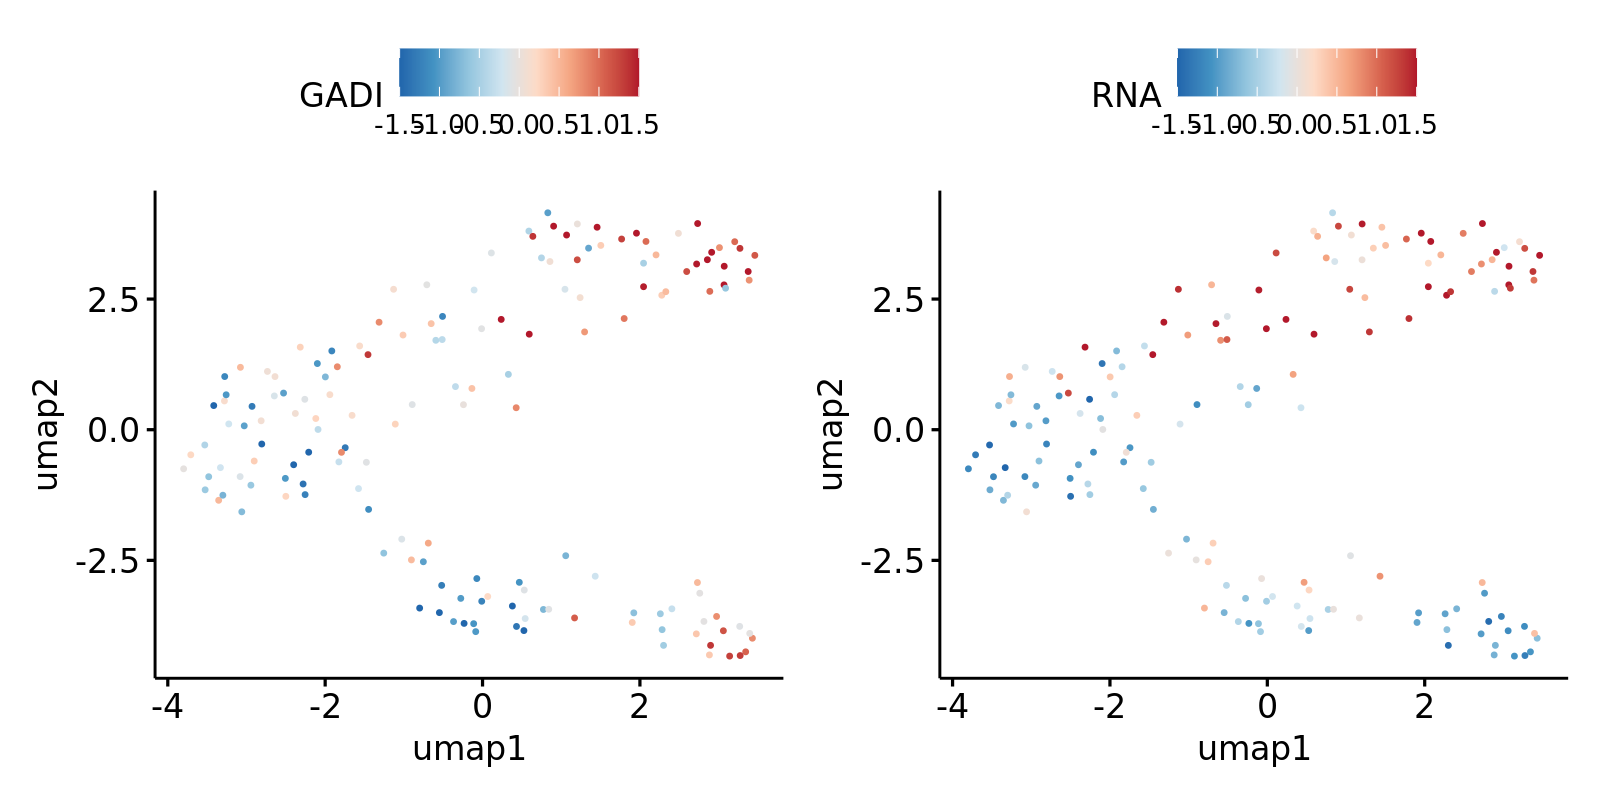

In [32]:
a <- plotdata %>% mutate(GADI = ifelse(GADI < -1.5, -1.5,GADI),GADI = ifelse(GADI > 1.5, 1.5,GADI)  )%>% 
ggscatter(x="umap1",y="umap2",color = "GADI",size = 0.5) + 
  scale_colour_gradientn(colours = rev(c('#b2182b','#d6604d','#f4a582','#fddbc7','#d1e5f0','#92c5de','#4393c3','#2166ac')))

b <- plotdata %>% mutate(RNA = ifelse(RNA < -1.5, -1.5,RNA),RNA = ifelse(RNA > 1.5, 1.5,RNA))%>%
    ggscatter(x="umap1",y="umap2",color = "RNA",size = 0.5) + 
  scale_colour_gradientn(colours = rev(c('#b2182b','#d6604d','#f4a582','#fddbc7','#d1e5f0','#92c5de','#4393c3','#2166ac'))) 

options(repr.plot.height = 4, repr.plot.width = 8 ,repr.plot.res = 200)
a | b

In [34]:
options(scipen = 3)

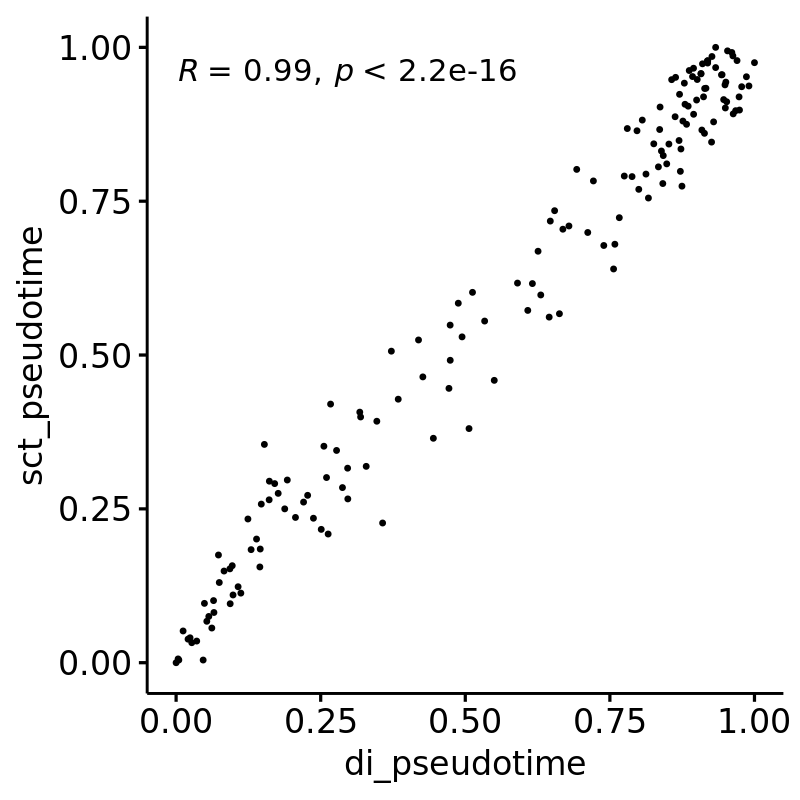

In [35]:
options(repr.plot.width = 4,repr.plot.height=4,repr.plot.res= 200)
p <- mc_hires[[]] %>% ggscatter(x="di_pseudotime",y="sct_pseudotime",cor.coef = T,size=0.5) #+ geom_smooth()
p

In [36]:
(p + theme_Publication()) %>% ggplot2::ggsave(filename = "pseudotime_corr.pdf",width = 1.5,height = 1.5,dpi=300)

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


In [37]:
p <- a + theme_Publication()+ NoLegend()+ theme(axis.ticks.x = element_blank(),
        axis.text.x = element_blank(),
         axis.ticks.y = element_blank(),
          axis.text.y = element_blank()) + xlab("DI UMAP 1") + ylab("DI UMAP 2") + ggtitle("")

q <- b + theme_Publication()+ NoLegend()+ theme(axis.ticks.x = element_blank(),
        axis.text.x = element_blank(),
         axis.ticks.y = element_blank(),
          axis.text.y = element_blank()) + xlab("DI UMAP 1") + ylab("DI UMAP 2") + ggtitle("")

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



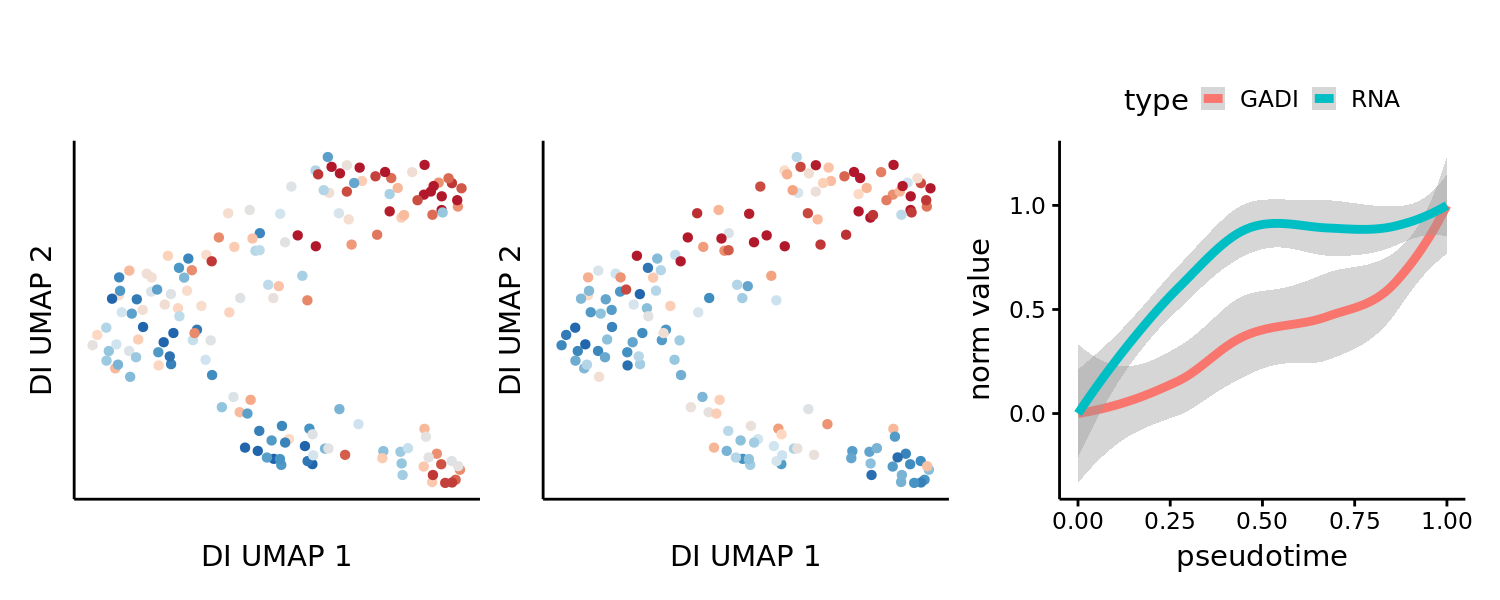

In [40]:
options(repr.plot.height = 2, repr.plot.width = 5 ,repr.plot.res = 300)
(p | q | lag)
(p | q | lag) %>% ggsave(filename = "residual_lag_example.pdf",height = 2, width =5,dpi=300,units ="in")

In [41]:
mm10 <- read_tsv("/share/Data/public/ref_genome/mouse_ref/M23/raw_data/gene.bed",col_names = F)
names(mm10) <- c("chrom","start","end","id","gene","strand")
mm10 <- mm10 %>% mutate(length = end - start) %>% arrange(desc(length)) %>% group_by(gene) %>% slice(1) %>% ungroup() %>% valr::bed_sort() %>% select(-length)
tss <- mm10 %>% mutate(tss = ifelse(strand == "+",start, end-1)) %>% mutate(name = gene)%>% select(name,tss,chrom,strand)

Rows: 55335 Columns: 6
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): X1, X4, X5, X6
dbl (2): X2, X3

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [82]:
options(repr.plot.height = 2, repr.plot.width = 2 ,repr.plot.res = 300)
rbind(neural_testRes,mesen_testRes) %>% filter(test_type == "lag") %>% mutate(name= gene) %>% left_join(tss) %>% mutate(left = tss -start1 - 10000,right = tss-start2-10000) %>% 
    mutate(logpv = -log10(pv))%>% mutate(left = ifelse(strand == "-",-left,left),right = ifelse(strand == "-",-right,right)) -> temp
temp <- rbind(temp %>% select(right,logpv),temp %>% mutate(right = left) %>% select(right,logpv))
a <- temp %>% gghistogram(x="right",bins=25) + scale_x_continuous(limits = c(-500000,500000)) + xlab("TSS") + theme_Publication() #+ ggtitle("Significant succeeding prositive cor")

options(repr.plot.height = 2, repr.plot.width = 2 ,repr.plot.res = 300)
rbind(neural_testRes,mesen_testRes) %>% filter(test_type == "early") %>% mutate(name= gene) %>% left_join(tss) %>% mutate(left = tss -start1 - 10000,right = tss-start2-10000) %>% 
    mutate(logpv = -log10(pv))%>% mutate(left = ifelse(strand == "-",-left,left),right = ifelse(strand == "-",-right,right))-> temp
temp <- rbind(temp %>% select(right,logpv),temp %>% mutate(right = left) %>% select(right,logpv))
b <- temp %>% gghistogram(x="right",bins=25) + scale_x_continuous(limits = c(-500000,500000)) + xlab("TSS") + theme_Publication() #+ ggtitle("Significant succeeding prositive cor")


Joining, by = "name"
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Joining, by = "name"
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


In [83]:
options(scipen = 3)

Warning message:
“Removed 8984 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 32051 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 8984 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 32051 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


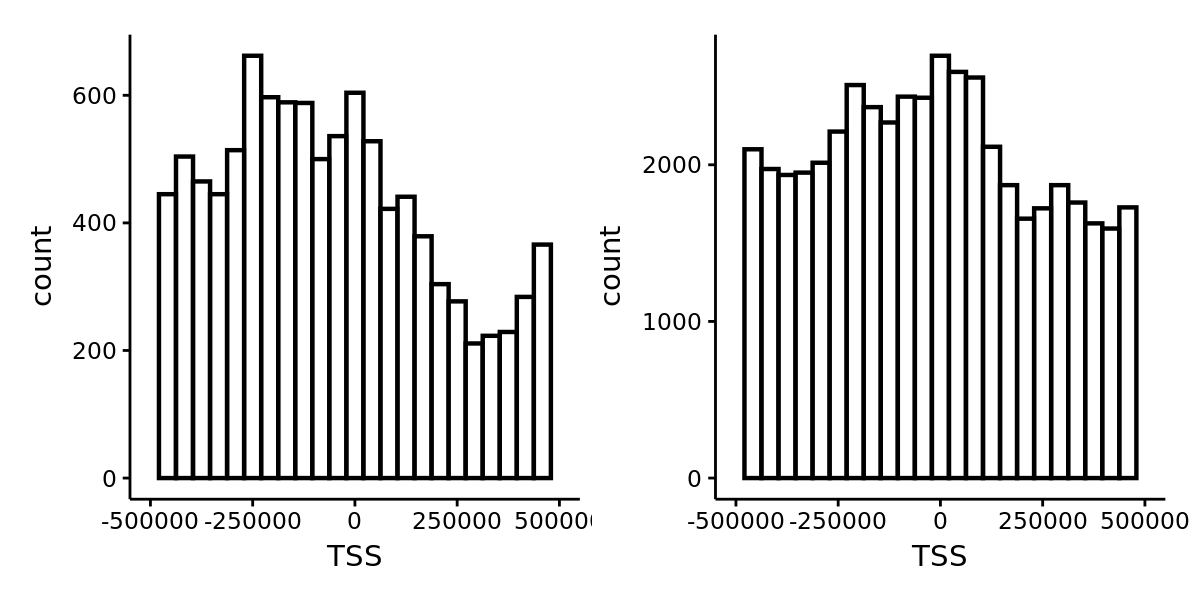

In [84]:
options(repr.plot.height = 2, repr.plot.width = 4 ,repr.plot.res = 300)
(a|b)
(a|b) %>% ggsave(filename = "earlylag_tssenrichment.pdf",height = 2, width =4,dpi=300,units ="in")

In [44]:
neural_testRes%>% filter(test_type == "early",gaditype=="pos") %>% mutate(name= gene) %>% left_join(tss) %>% mutate(left = tss -start1 - 10000,right = tss-start2-10000) %>% 
    mutate(logpv = -log10(pv))%>% mutate(left = ifelse(strand == "-",-left,left),right = ifelse(strand == "-",-right,right)) -> temp
temp <- rbind(temp %>% select(right,logpv),temp %>% mutate(right = left) %>% select(right,logpv))
a <- temp %>% gghistogram(x="right",bins=25) + scale_x_continuous(limits = c(-500000,500000)) + xlab("TSS") + theme_Publication()
options(repr.plot.height = 2, repr.plot.width = 2 ,repr.plot.res = 300)
a %>% ggsave(filename = "earlynegcor_tssenrichment_neural.pdf",height = 2, width =2,dpi=300,units ="in")

Joining, by = "name"
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“Removed 4495 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


Warning message:
“Removed 4495 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


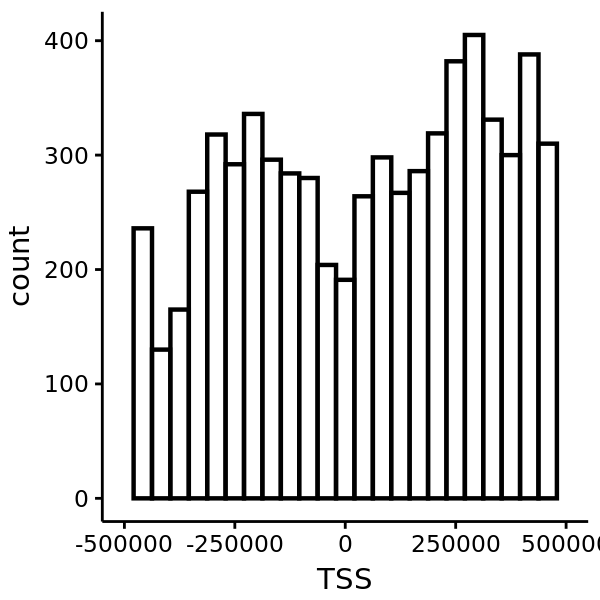

In [45]:
a

In [ ]:
# epigenetic enrichment

In [48]:
# load features track
forebrain_H3K27ac <- read_tsv("/share/Data/mliu/project1/histone_data/ENCSR275KPI_H3K27ac_forebrain_e115.bed.gz",col_names = FALSE) %>% select(1:3) %>% suppressMessages() 
forebrain_atac <- read_tsv("/share/Data/mliu/project1/histone_data/ENCSR273UFV_nan_forebrain_e115.bed.gz",col_names = FALSE) %>% select(1:3)%>% suppressMessages() 
forebrain_H3K9ac <- read_tsv("/share/Data/mliu/project1/histone_data/ENCSR400TGE_H3K9ac_forebrain_e115.bed.gz",col_names = FALSE) %>% select(1:3)%>% suppressMessages() 
forebrain_H3K4me3 <- read_tsv("/share/Data/mliu/project1/histone_data/ENCSR739DVM_H3K4me3_forebrain_e115.bed.gz",col_names = FALSE) %>% select(1:3)%>% suppressMessages() 
forebrain_H3K9me3 <- read_tsv("/share/Data/mliu/project1/histone_data/ENCSR894JAS_H3K9me3_forebrain_e115.bed.gz",col_names = FALSE) %>% select(1:3)%>% suppressMessages() 
forebrain_H3K27me3 <- read_tsv("/share/Data/mliu/project1/histone_data/ENCSR944XPB_H3K27me3_forebrain_e115.bed.gz",col_names = FALSE) %>% select(1:3)%>% suppressMessages() 
forebrain_H3K4me1 <- read_tsv("/share/Data/mliu/project1/histone_data/ENCSR975QSF_H3K4me1_forebrain_e115.bed.gz",col_names = FALSE) %>% select(1:3)%>% suppressMessages() 
forebrain_H3K36me3 <- read_tsv("/share/Data/mliu/project1/histone_data/ENCSR066LZB_H3K36me3_forebrain_e115.bed.gz",col_names = FALSE) %>% select(1:3)%>% suppressMessages() 

limb_H3K27ac <- read_tsv("/share/Data/mliu/project1/histone_data/ENCSR897WBY_H3K27ac_limb_e115.bed.gz",col_names = FALSE) %>% select(1:3)%>% suppressMessages() 
limb_atac <- read_tsv("/share/Data/mliu/project1/histone_data/ENCSR377YDY_nan_limb_e115.bed.gz",col_names = FALSE) %>% select(1:3)%>% suppressMessages() 
limb_H3K9ac <- read_tsv("/share/Data/mliu/project1/histone_data/ENCSR286IGS_H3K9ac_limb_e115.bed.gz",col_names = FALSE) %>% select(1:3)%>% suppressMessages() 
limb_H3K4me3 <- read_tsv("/share/Data/mliu/project1/histone_data/ENCSR654VMK_H3K4me3_limb_e115.bed.gz",col_names = FALSE) %>% select(1:3)%>% suppressMessages() 
limb_H3K9me3 <- read_tsv("/share/Data/mliu/project1/histone_data/ENCSR961MEP_H3K9me3_limb_e115.bed.gz",col_names = FALSE) %>% select(1:3)%>% suppressMessages() 
limb_H3K27me3 <- read_tsv("/share/Data/mliu/project1/histone_data/ENCSR085EYQ_H3K27me3_limb_e115.bed.gz",col_names = FALSE) %>% select(1:3)%>% suppressMessages() 
limb_H3K4me1 <- read_tsv("/share/Data/mliu/project1/histone_data/ENCSR548BCO_H3K4me1_limb_e115.bed.gz",col_names = FALSE) %>% select(1:3)%>% suppressMessages() 
limb_H3K36me3 <- read_tsv("/share/Data/mliu/project1/histone_data/ENCSR871YCT_H3K36me3_limb_e115.bed.gz",col_names = FALSE) %>% select(1:3)%>% suppressMessages() 

In [49]:
plot_dynamic_enrichment <- function(testRes,gadi_type,feature_bed,title,numbin = 100,outdir="residual_enrichment",save= TRUE){
    feature = deparse(substitute(feature_bed))
    neural_testRes_rank <- testRes %>% filter(gaditype==gadi_type) %>% arrange(desc(residual)) %>% mutate(rankgroup = ntile(seq(n()),numbin)) %>% ungroup()
    types <- neural_testRes_rank %>% 
        group_by(rankgroup, test_type) %>% 
        mutate(votes = n()) %>% 
        group_by(rankgroup) %>% 
        summarise(majority_vote = test_type[votes > n()/2][1]) %>% pull(majority_vote)
    map(seq(numbin), function(x) {overlap_ratio(neural_testRes_rank %>% filter(rankgroup ==x) ,feature_bed)[2]}) %>% unlist() -> residual_enrich

    options(repr.plot.width = 4.5,repr.plot.height=5,repr.plot.res= 200)
    p <- cbind(seq(numbin),types,residual_enrich) %>% as.data.frame() %>% 
        mutate(V1=as.numeric(V1),residual_enrich = as.numeric(residual_enrich)) %>% 
        mutate(types = ifelse(types=="early","Proceeding",ifelse(types=="lag","Succeeding","Not Sig")))%>% 
       ggscatter(x="V1",y="residual_enrich",color="types",palette = c("Proceeding"="#b2182b","Not Sig"="#969696","Succeeding"="#2166ac"),size = 0.5) + 
        ylab(paste0("% of ",feature)) + xlab("Residual group rank") + 
        theme_Publication() #+ ggtitle(title)#+ scale_y_continuous(limits = c(0.2,0.55))
    if(save ==TRUE){
        (p+theme_Publication()+ NoLegend()) %>% ggsave(filename = paste0(outdir,"/",title,"_",feature,".pdf"),width = 1.5,height=1.5)
    }
    return(1)
}

In [50]:
plot_dynamic_enrichment(neural_testRes,"neg",forebrain_H3K27ac,"Ecto lineage, positive gadi")
plot_dynamic_enrichment(neural_testRes,"pos",forebrain_H3K27ac,"Ecto lineage, negative gadi")
plot_dynamic_enrichment(neural_testRes,"neg",forebrain_atac,"Ecto lineage, positive gadi")
plot_dynamic_enrichment(neural_testRes,"pos",forebrain_atac,"Ecto lineage, negative gadi")
plot_dynamic_enrichment(neural_testRes,"neg",forebrain_H3K9ac,"Ecto lineage, positive gadi")
plot_dynamic_enrichment(neural_testRes,"pos",forebrain_H3K9ac,"Ecto lineage, negative gadi")
plot_dynamic_enrichment(neural_testRes,"neg",forebrain_H3K4me3,"Ecto lineage, positive gadi")
plot_dynamic_enrichment(neural_testRes,"pos",forebrain_H3K4me3,"Ecto lineage, negative gadi")
plot_dynamic_enrichment(neural_testRes,"neg",forebrain_H3K9me3,"Ecto lineage, positive gadi")
plot_dynamic_enrichment(neural_testRes,"pos",forebrain_H3K9me3,"Ecto lineage, negative gadi")
plot_dynamic_enrichment(neural_testRes,"neg",forebrain_H3K27me3,"Ecto lineage, positive gadi")
plot_dynamic_enrichment(neural_testRes,"pos",forebrain_H3K27me3,"Ecto lineage, negative gadi")
plot_dynamic_enrichment(neural_testRes,"neg",forebrain_H3K4me1,"Ecto lineage, positive gadi")
plot_dynamic_enrichment(neural_testRes,"pos",forebrain_H3K4me1,"Ecto lineage, negative gadi")

plot_dynamic_enrichment(mesen_testRes,"neg",limb_H3K27ac,"Meso lineage, positive gadi")
plot_dynamic_enrichment(mesen_testRes,"pos",limb_H3K27ac,"Meso lineage, negative gadi")
plot_dynamic_enrichment(mesen_testRes,"neg",limb_atac,"Meso lineage, positive gadi")
plot_dynamic_enrichment(mesen_testRes,"pos",limb_atac,"Meso lineage, negative gadi")
plot_dynamic_enrichment(mesen_testRes,"neg",limb_H3K9ac,"Meso lineage, positive gadi")
plot_dynamic_enrichment(mesen_testRes,"pos",limb_H3K9ac,"Meso lineage, negative gadi")
plot_dynamic_enrichment(mesen_testRes,"neg",limb_H3K4me3,"Meso lineage, positive gadi")
plot_dynamic_enrichment(mesen_testRes,"pos",limb_H3K4me3,"Meso lineage, negative gadi")
plot_dynamic_enrichment(mesen_testRes,"neg",limb_H3K9me3,"Meso lineage, positive gadi")
plot_dynamic_enrichment(mesen_testRes,"pos",limb_H3K9me3,"Meso lineage, negative gadi")
plot_dynamic_enrichment(mesen_testRes,"neg",limb_H3K27me3,"Meso lineage, positive gadi")
plot_dynamic_enrichment(mesen_testRes,"pos",limb_H3K27me3,"Meso lineage, negative gadi")
plot_dynamic_enrichment(mesen_testRes,"neg",limb_H3K4me1,"Meso lineage, positive gadi")
plot_dynamic_enrichment(mesen_testRes,"pos",limb_H3K4me1,"Meso lineage, negative gadi")

plot_dynamic_enrichment(neural_testRes,"neg",forebrain_H3K36me3,"Ecto lineage, positive gadi")
plot_dynamic_enrichment(neural_testRes,"pos",forebrain_H3K36me3,"Ecto lineage, negative gadi")
plot_dynamic_enrichment(mesen_testRes,"neg",limb_H3K36me3,"Meso lineage, positive gadi")
plot_dynamic_enrichment(mesen_testRes,"pos",limb_H3K36me3,"Meso lineage, negative gadi")

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


[1] 1

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


[1] 1

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


[1] 1

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


[1] 1

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


[1] 1

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


[1] 1

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


[1] 1

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


[1] 1

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


[1] 1

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


[1] 1

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


[1] 1

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


[1] 1

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


[1] 1

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


[1] 1

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


[1] 1

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


[1] 1

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


[1] 1

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


[1] 1

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


[1] 1

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


[1] 1

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


[1] 1

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


[1] 1

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


[1] 1

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


[1] 1

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


[1] 1

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


[1] 1

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


[1] 1

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


[1] 1

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


[1] 1

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


[1] 1

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


[1] 1

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


[1] 1

In [87]:
neuron_E1 <- read_tsv("/shareb/zliu/analysis/hires_mouse_dev/figure3_related/pileup/processed/compartment/early_neurons.compartment.100k.cis.vecs.tsv")%>% select(chrom,start,end,E1) %>% na.omit()
mesenchyme_E1 <- read_tsv("/shareb/zliu/analysis/hires_mouse_dev/figure3_related/pileup/processed/compartment/mix_late_mesenchyme.compartment.100k.cis.vecs.tsv")%>% select(chrom,start,end,E1) %>% na.omit()

Rows: 27268 Columns: 7
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): chrom
dbl (6): start, end, weight, E1, E2, E3

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 27268 Columns: 7
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): chrom
dbl (6): start, end, weight, E1, E2, E3

ℹ Use `spec()` to retrieve the full co

In [88]:
temp <- neural_testRes %>% select(test_type,gene,gaditype)  %>% filter(test_type == "early") %>% 
    group_by(gene,gaditype) %>% summarise(count = n()) %>% spread(gaditype,count) 
temp[is.na(temp)] <- 0
ecto_earlygene <- temp %>% mutate(neg_t = (neg>5),pos_t = (pos>5),type = ifelse(neg_t &(!pos_t),"pos corr",
                                                        ifelse((!neg_t)&pos_t,"neg corr","else"))) %>%
    filter(type != "else") %>% mutate(lineagetype = "Ecto")

temp <- mesen_testRes %>% select(test_type,gene,gaditype)  %>% filter(test_type == "early") %>% 
    group_by(gene,gaditype) %>% summarise(count = n()) %>% spread(gaditype,count) 
temp[is.na(temp)] <- 0
meso_earlygene <- temp %>% mutate(neg_t = (neg>5),pos_t = (pos>5),type = ifelse(neg_t &(!pos_t),"pos corr",
                                                        ifelse((!neg_t)&pos_t,"neg corr","else"))) %>%
    filter(type != "else") %>% mutate(lineagetype = "Meso")

`summarise()` has grouped output by 'gene'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'gene'. You can override using the `.groups` argument.


In [89]:
ecto_earlygene_E1 <- ecto_earlygene %>% left_join(mm10) %>% mutate(start = start - 100000,end= end+100000) %>% 
   ungroup()%>% select(chrom,start,end,type,lineagetype,gene) %>% valr::bed_intersect(neuron_E1) %>%
    group_by(type.x,lineagetype.x,gene.x) # %>% summarise(E1 = mean(E1.y,na.rm=T)) # %>% ggviolin(x="type.x",y="E1",add="boxplot") + stat_compare_means(method="t.test")

meso_earlygene_E1 <- meso_earlygene %>% left_join(mm10) %>% mutate(start = start - 100000,end= end+100000) %>% 
   ungroup()%>% select(chrom,start,end,type,lineagetype,gene) %>% valr::bed_intersect(mesenchyme_E1) %>%
    group_by(type.x,lineagetype.x,gene.x) #%>% summarise(E1 = mean(E1.y,na.rm=T))  #%>% ggviolin(x="type.x",y="E1",add="boxplot") + stat_compare_means(method="t.test")

Joining, by = "gene"
Joining, by = "gene"


In [90]:
earlygeneE1 <- rbind(ecto_earlygene_E1,meso_earlygene_E1)

In [99]:
earlygeneE1 %>% filter(type.x == "neg corr",lineagetype.x == "Ecto") %>% pull(gene.x) %>% unique()

[1] "9330159F19Rik" "Gm49353"       "Soga3"         "Unc79"        
 [5] "Spock1"        "Cadps"         "App"           "Rcan2"        
 [9] "4930402H24Rik" "Scg5"          "Gm21954"       "Gm42609"      
[13] "Zfp618"        "Gm42439"       "Gm42853"       "Gm42991"      
[17] "Svop"          "A230057D06Rik" "A330076H08Rik" "Ebf3"         
[21] "Gm9801"        "Evi5l"         "Sorbs2"        "Sorbs2os"

In [95]:
options(repr.plot.height =4.5,repr.plot.width = 4,repr.plot.res = 200,scipen=-3)
p <- earlygeneE1 %>% ungroup() %>% mutate(E1 = E1.y) %>% mutate(type = paste0(lineagetype.x,"_",type.x)) %>% 
    #group_by(gene.x) %>%  mutate(count = n()) %>% filter(count == 1) %>% 
    ggviolin(x="type",y="E1",add="boxplot")  + theme_Publication() + 
    theme(axis.text.x = element_text(angle = 25, vjust = 1, hjust=0.8)) + xlab("") + scale_y_continuous(limits = c(-2,2)) + 
    stat_compare_means(method="anova", label.y=-2) + 
    stat_compare_means(method="t.test",aes(label = ..p.format..),
                       ref.group = "Ecto_neg corr")

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


Warning message:
“Removed 41 rows containing missing values (geom_violin).”


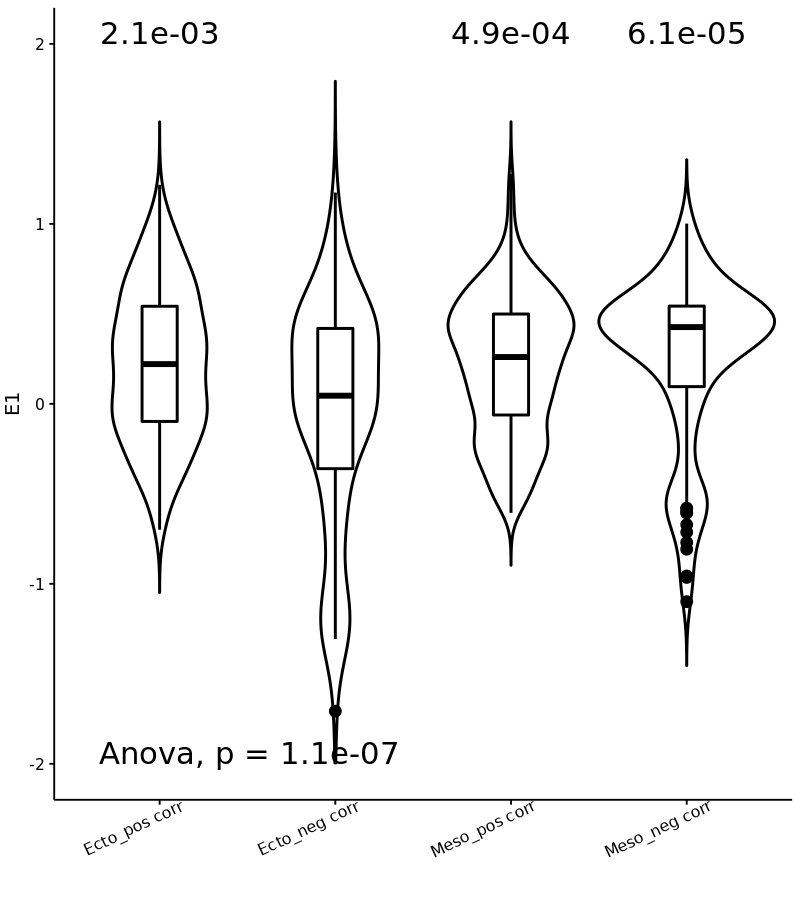

In [94]:
p

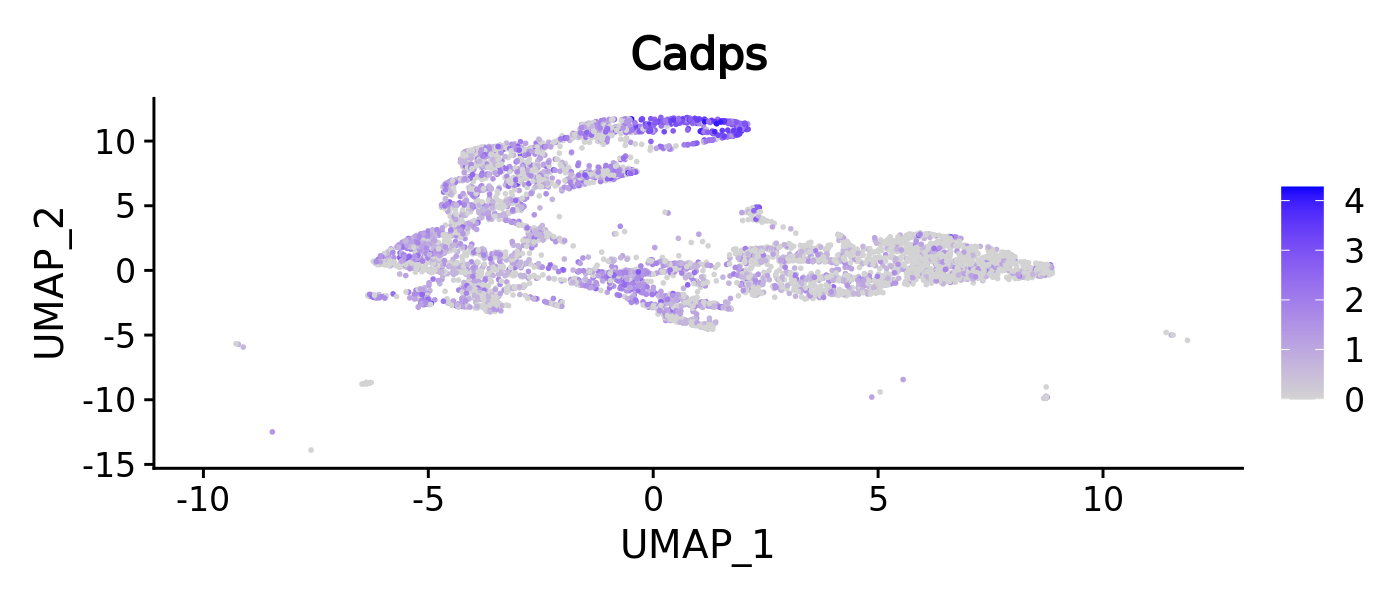

In [107]:
FeaturePlot(hires,features = c("Cadps"))

In [128]:
earlygeneE1 %>% filter(type.x == "neg corr",lineagetype.x=="Ecto") %>% filter(E1.y < 0) %>% arrange(desc(gene.x))

chrom,start.x,end.x,type.x,lineagetype.x,gene.x,start.y,end.y,E1.y,.overlap
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>
chr4,62865572,63239708,neg corr,Ecto,Zfp618,6.280e+07,6.290e+07,-4.087687e-02,34428
chr4,62865572,63239708,neg corr,Ecto,Zfp618,6.290e+07,6.300e+07,-7.073518e-02,100000
chr8,45623324,45919297,neg corr,Ecto,Sorbs2os,4.560e+07,4.570e+07,-1.514543e-02,76676
chr8,45623324,45919297,neg corr,Ecto,Sorbs2os,4.570e+07,4.580e+07,-6.460189e-02,100000
chr8,45407787,45927906,neg corr,Ecto,Sorbs2,4.560e+07,4.570e+07,-1.514543e-02,100000
chr8,45407787,45927906,neg corr,Ecto,Sorbs2,4.570e+07,4.580e+07,-6.460189e-02,100000
chr10,29043838,29299630,neg corr,Ecto,Soga3,2.900e+07,2.910e+07,-7.781286e-01,56162
chr10,29043838,29299630,neg corr,Ecto,Soga3,2.910e+07,2.920e+07,-1.303491e-01,100000
chr10,29043838,29299630,neg corr,Ecto,Soga3,2.920e+07,2.930e+07,-3.933764e-01,99630


In [56]:
p %>% ggsave(filename = "E1.pdf",height = 2, width =2,dpi=300,units ="in")

Warning message:
“Removed 41 rows containing missing values (geom_violin).”


# ARC

In [101]:
library(ggbio)

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Need specific help about ggbio? try mailing 
 the maintainer or visit https://lawremi.github.io/ggbio/


Attaching package: 'ggbio'


The following objects are masked from 'package:ggplot2':

    geom_bar, geo

In [111]:
library(GenomicRanges)

Loading required package: stats4

Loading required package: S4Vectors


Attaching package: 'S4Vectors'


The following objects are masked from 'package:dplyr':

    first, rename


The following object is masked from 'package:tidyr':

    expand


The following objects are masked from 'package:base':

    expand.grid, I, unname


Loading required package: IRanges


Attaching package: 'IRanges'


The following objects are masked from 'package:dplyr':

    collapse, desc, slice


The following object is masked from 'package:purrr':

    reduce


Loading required package: GenomeInfoDb



In [ ]:
options(scipen = 9)

Warning message:
"`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing"


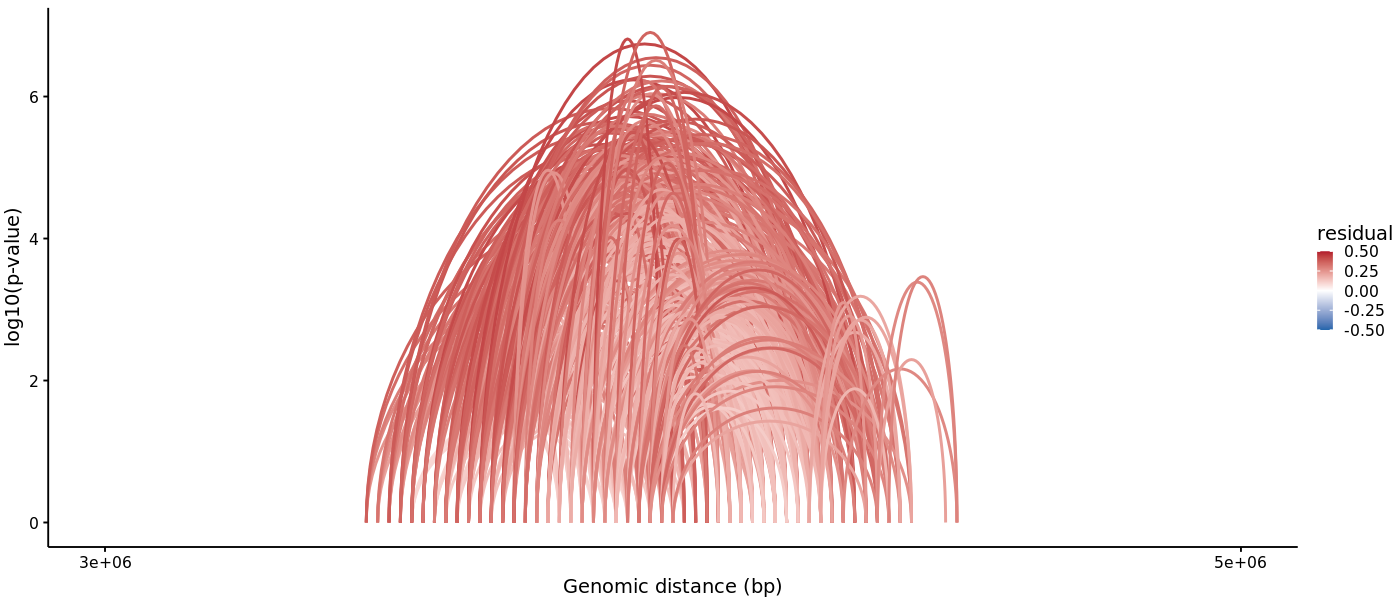

In [132]:
startc =3000000
endc = 5000000
#gene = "Dcc"
options(repr.plot.width = 7,repr.plot.height = 3,repr.plot.res = 200)

P <- neural_testRes %>% filter(gene == "Evi5l",gaditype == "pos",test_type == "early") %>% mutate(logpv = -log10(pv),chrom = chrom1,start = start1 + 10000,end = start2 + 10000) %>% 
    select(chrom,start,end,logpv,residual)   %>% GRanges() %>% ggplot() + geom_arch(aes(color = residual, height = logpv))+#,alpha = (logpv-min(logpv))/(max(logpv)-min(logpv)))) +
        theme_Publication() +  theme(legend.position = "right", legend.direction = "vertical") + 
        scale_color_gradient2(low = "#2166ac",mid = "white",high = "#b2182b",limits = c(-0.5,0.5))  + 
        ylab("log10(p-value)") + xlab("Genomic distance (bp)") + scale_x_continuous(limits = c(startc,endc),breaks = c(startc,endc)) 
P

In [133]:
pdf("Evi5l.pdf", width = 2.5, height = 1)
P
dev.off() 

png 
  2